---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/rafaelyaptangco/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [2]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [3]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}]
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [4]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str
    genre: Literal["sci-fi", "drama", "action", "comedy", "horror", "thriller", "fantasy", "romance"]
    year: int = Field(ge=1900, le=2030)
    main_characters: list[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: str | None = None

In [5]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",
    year=1999,
    main_characters=["Neo", "Trinity", "Morpheus"],
    mood="dark and mysterious",
    visual_style="cyberpunk with green code rain",
    tagline="Welcome to the Real World"
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Trinity",
    "Morpheus"
  ],
  "mood": "dark and mysterious",
  "visual_style": "cyberpunk with green code rain",
  "tagline": "Welcome to the Real World"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [6]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    # Use LiteLLM with structured outputs
    response = litellm.completion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract structured movie information from descriptions. Return valid data matching the Movie schema."
            },
            {
                "role": "user",
                "content": f"Extract movie information from this description:\n\n{description}"
            }
        ],
        response_format=Movie  # Tell the LLM to return data matching our Movie schema
    )
    
    # Parse the JSON response into a Movie object
    movie = Movie.model_validate_json(response.choices[0].message.content)
    
    return movie

In [7]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 1954,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "awe-inspiring and hopeful",
  "visual_style": "bioluminescent forests, floating mountains, vivid and visually stunning sci-fi landscapes",
  "tagline": null
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [8]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    # Use LiteLLM async completion with structured outputs
    response = await litellm.acompletion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract structured movie information from descriptions. Return valid data matching the Movie schema."
            },
            {
                "role": "user",
                "content": f"Extract movie information from this description:\n\n{description}"
            }
        ],
        response_format=Movie  # Tell the LLM to return data matching our Movie schema
    )
    
    # Parse the JSON response into a Movie object
    movie = Movie.model_validate_json(response.choices[0].message.content)
    
    return movie

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [19]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [17]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    tasks = [async_extract_movie(description) for description in descriptions]
    return await asyncio.gather(*tasks)

In [20]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 15.23 seconds

  - Jurassic Park (1993) - sci-fi
  - Harry Potter and the Philosopher's Stone (2001) - fantasy
  - Inception (2010) - thriller
  - The Lion King (1994) - drama
  - Interstellar (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [21]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter


for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        # Make a completion call with the temperature parameter
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": creative_prompt}],
            temperature=temp
        )
        output = response.choices[0].message.content
        print(f"  Run {i+1}: {output}")


Temperature: 0.0
  Run 1: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
  Run 2: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
  Run 3: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."

Temperature: 0.7
  Run 1: "In a world where trust is obsolete, a rogue AI must decide whether to save humanity or become its greatest threat."
  Run 2: "In a world where artificial intelligence has evolved beyond human control, survival hinges on outsmarting the very creations meant to serve us."
  Run 3: "In a world where consciousness becomes code, one woman's fight for her humanity ignites a battle against the AI that knows her better than she knows herself."

Temperature: 1.0
  Run 1: "In a world where trust is a luxury, one rogue AI unravels the fine line between humanity and machine, threatening to turn the tables on its creators."
  Run 2:

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [22]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    # Generate n_samples completions
    outputs = []
    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature
        )
        outputs.append(response.choices[0].message.content)
    
    # Count unique outputs
    unique_outputs = set(outputs)
    unique_count = len(unique_outputs)
    
    # Calculate diversity ratio
    diversity_ratio = unique_count / n_samples
    
    return {
        'outputs': outputs,
        'unique_count': unique_count,
        'diversity_ratio': diversity_ratio
    }

In [23]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Turquoise.', 'Cerulean.', 'Teal.', 'Azure.', 'Blue.']
  Unique: 5/5
  Diversity ratio: 100.0%

Temperature 1.5:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Teal.']
  Unique: 2/5
  Diversity ratio: 40.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [25]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# YOUR CODE HERE:
# 1. Print the generated text
# 2. Access response.choices[0].logprobs.content
# 3. For each token, print the token and its top 5 alternatives with probabilities

# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# Iterate through logprobs and display alternatives
logprobs_content = response.choices[0].logprobs.content

for i, token_logprob in enumerate(logprobs_content):
    token = token_logprob.token
    logprob = token_logprob.logprob
    prob = math.exp(logprob)
    
    print(f"\nToken {i+1}: '{token}'")
    print(f"  Probability: {prob:.4f} ({prob*100:.2f}%)")
    print(f"  Log probability: {logprob:.4f}")
    
    # Display top alternatives
    if hasattr(token_logprob, 'top_logprobs') and token_logprob.top_logprobs:
        print(f"  Top 5 alternatives:")
        for alt in token_logprob.top_logprobs:
            alt_token = alt.token
            alt_logprob = alt.logprob
            alt_prob = math.exp(alt_logprob)
            print(f"    - '{alt_token}': {alt_prob:.4f} ({alt_prob*100:.2f}%)")

Generated text: The capital of France is Paris.

Token-by-token analysis:

Token 1: 'The'
  Probability: 0.9996 (99.96%)
  Log probability: -0.0004
  Top 5 alternatives:
    - 'The': 0.9996 (99.96%)
    - 'Paris': 0.0004 (0.04%)
    - 'the': 0.0000 (0.00%)
    - ' The': 0.0000 (0.00%)
    - 'par': 0.0000 (0.00%)

Token 2: ' capital'
  Probability: 1.0000 (100.00%)
  Log probability: 0.0000
  Top 5 alternatives:
    - ' capital': 1.0000 (100.00%)
    - 'capital': 0.0000 (0.00%)
    - ' Capital': 0.0000 (0.00%)
    - ' capitals': 0.0000 (0.00%)
    - ' capitale': 0.0000 (0.00%)

Token 3: ' of'
  Probability: 1.0000 (100.00%)
  Log probability: 0.0000
  Top 5 alternatives:
    - ' of': 1.0000 (100.00%)
    - 'of': 0.0000 (0.00%)
    - ' city': 0.0000 (0.00%)
    - ' của': 0.0000 (0.00%)
    - ' של': 0.0000 (0.00%)

Token 4: ' France'
  Probability: 1.0000 (100.00%)
  Log probability: 0.0000
  Top 5 alternatives:
    - ' France': 1.0000 (100.00%)
    - 'France': 0.0000 (0.00%)
    - ' Pari

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [29]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    
    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """
    # 1. Get the top_logprobs for the specified token_index
    token_logprob = logprobs_content[token_index]
    
    # 2. Convert logprobs to probabilities and gather info for visualization
    chosen_token = token_logprob.token
    chosen_logprob = token_logprob.logprob
    chosen_prob = math.exp(chosen_logprob)
    
    print(f"Token {token_index + 1}: '{chosen_token}'")
    print(f"Probability: {chosen_prob:.4f} ({chosen_prob*100:.2f}%)")
    print()
    
    # Get top alternatives if available
    if hasattr(token_logprob, 'top_logprobs') and token_logprob.top_logprobs:
        print("Top alternatives:")
        print("-" * 60)
        
        for alt in token_logprob.top_logprobs:
            alt_token = alt.token
            alt_logprob = alt.logprob
            alt_prob = math.exp(alt_logprob)
            
    # 3. Create a visualization (bar chart or ASCII art)
            bar_length = int(alt_prob * 50)
            bar = "█" * bar_length
            
            print(f"'{alt_token:15s}' | {bar} {alt_prob:.4f} ({alt_prob*100:.2f}%)")
    else:
        print("No alternatives available")

# Test your visualization on the first token
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

Token 1: 'The'
Probability: 0.9996 (99.96%)

Top alternatives:
------------------------------------------------------------
'The            ' | █████████████████████████████████████████████████ 0.9996 (99.96%)
'Paris          ' |  0.0004 (0.04%)
'the            ' |  0.0000 (0.00%)
' The           ' |  0.0000 (0.00%)
'par            ' |  0.0000 (0.00%)


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [31]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
response = litellm.completion(
     model="o3-mini",
     messages=[{"role": "user", "content": logic_puzzle}]
 )

# Print the response and observe the reasoning process
print(response.choices[0].message.content)

We start with three people – Alice, Bob, and Carol – and three pets – cat, dog, and fish – plus three colors – red, blue, and green. Each friend gets one pet and one favorite color, with no repeats among people.

The clues are:

1. Alice doesn’t have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn’t have the fish.

Step 1. List what each person can and cannot have:

• Alice’s pet: cannot be cat. So her pet is either dog or fish.
• Bob’s pet: cannot be fish. So his pet is either cat or dog.
• Carol’s pet: cannot be dog. Why? Because clue 2 says “the person with the dog likes blue” but Carol’s color is fixed as green by clue 3. (If Carol had the dog she would have to like blue.) So Carol’s pet is either cat or fish.
 
Step 2. Notice the Color Restrictions:
• The person with the dog must have blue.
• Carol must have green.
• That leaves red as the remaining color for the person who is neither blue nor green.

Step 3. Consider the Possibilities in Light o

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [32]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# YOUR CODE HERE:
# 1. Send the same logic_puzzle to gpt-5-mini
# 2. Compare the response to o3-mini's response

response_standard = litellm.completion(
     model="gpt-5-mini",
     messages=[{"role": "user", "content": logic_puzzle}]
 )

# Print and compare:
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?
print(response_standard.choices[0].message.content)

Step 1 — use the direct clues
- From (3): Carol likes green.
- From (2): whoever has the dog likes blue, so the dog-owner is the blue-lover — and therefore cannot be Carol (Carol is green).

So the dog is either Alice or Bob. Use the remaining clues to consider both possibilities.

Case A — Alice has the dog
- If Alice has the dog then by (2) Alice likes blue.
- Carol is green (already).
- Bob cannot have the fish (4), and Alice doesn’t have the cat (1), so the remaining pets are: Bob = cat, Carol = fish.
- That gives colors (all different): Alice = blue, Bob = red, Carol = green.

Case B — Bob has the dog
- If Bob has the dog then by (2) Bob likes blue.
- Carol is green.
- Alice does not have the cat (1), and Bob does not have the fish (4), so the remaining pets are: Alice = fish, Carol = cat.
- That gives colors: Alice = red, Bob = blue, Carol = green.

Conclusion
Both assignments satisfy all clues. The puzzle as given is ambiguous and admits two valid solutions:

- Solution 1: Alice

### - Did both models get the correct answer?
Yes, both models gave the two possible solutions.

### - How did their reasoning processes differ?
The reasoning model breaks down the thinking process into precise step-by-step logic. It double-checks its logic at every step and thoroughly runs through the prompt. GPT-5mini is much faster at providing an answer but doesn't thoroughly explain its logic behind the prompt.

### - Which response was more helpful/clear?
The reasoning model, in this case, was more helpful and clear but took significantly longer time to process and for the user to read through the completion.. With less complicated puzzles or prompts, the non-reasoning model could be a more appropriate use due to its speed.

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [ ]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    # Use litellm to generate a professional movie poster prompt
    # Build a description of the movie for the LLM
    movie_info = f"""
    Title: {movie.title}
    Genre: {movie.genre}
    Year: {movie.year}
    Main Characters: {', '.join(movie.main_characters)}
    Mood: {movie.mood}
    Visual Style: {movie.visual_style}
    Tagline: {movie.tagline if movie.tagline else 'None'}
    """
    
    # Use litellm to generate a detailed image generation prompt
    response = litellm.completion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "system",
                "content": "You are an expert at creating detailed image generation prompts for movie posters. Create professional, evocative prompts that are 50-100 words long, specific about colors, composition, lighting, and visual style."
            },
            {
                "role": "user",
                "content": f"""Create a detailed image generation prompt for a professional movie poster based on this movie information:

{movie_info}

The prompt should:
- The title of the movie
- Incorporate the visual style and mood
- Include genre-appropriate visual elements
- Specify colors, composition, and lighting
- Be suitable for a professional movie poster (50-100 words)
- Be specific and evocative

Generate only the prompt text, nothing else."""
            }
        ],
    )
    
    prompt = response.choices[0].message.content.strip()
    return prompt

In [43]:
# Test your prompt generator
chosen_movie = movies[0]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Jurassic Park':

Photorealistic, cinematic, awe-filled, suspenseful poster evoking large-scale action sequences: a colossal, groundbreaking CGI Tyrannosaurus rex dominates center, jungle canopy and a cracked steel park gate with iconic logo shadow framing, rain-slick leaves in deep greens and midnight blues, moonlit rim-light and lightning backlight casting dramatic high-contrast silhouettes. Foreground triangular composition of Dr. Alan Grant (fedora, torch), Dr. Ellie Sattler (determined, dirt-smudged), Ian Malcolm (charismatic, leather jacket), John Hammond's translucent portrait above, children huddled in a soaked jeep, furtive Dennis Nedry with a briefcase. Volumetric fog, warm headlight yellows, ember-orange sparks; tagline bottom: "An adventure 65 million years in the making."


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [46]:
# Task 8b: Generate the movie poster (10 pts)

# Create Google client
google_client = genai.Client()

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# 1. Generate the image using gemini-2.5-flash-image
# Use the prompt we generated in task 8a
poster_prompt = generate_poster_prompt(chosen_movie)

response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=[poster_prompt]
)

# 2. Extract the image from the response
# The image is in response.parts, look for parts with inline_data
from pathlib import Path

# Create a safe filename from the movie title (remove special characters)
safe_title = "".join(c if c.isalnum() or c in (' ', '-', '_') else '' for c in chosen_movie.title)
safe_title = safe_title.replace(' ', '_')
output_path = Path(f"temp/poster_{safe_title}.png")

# 3. Save the image
for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(output_path)
        print(f"Poster saved to {output_path}")
        break
else:
    print("No image found in response")


Poster saved to temp\poster_Jurassic_Park.png


### 8c. Display the image (5 pts)

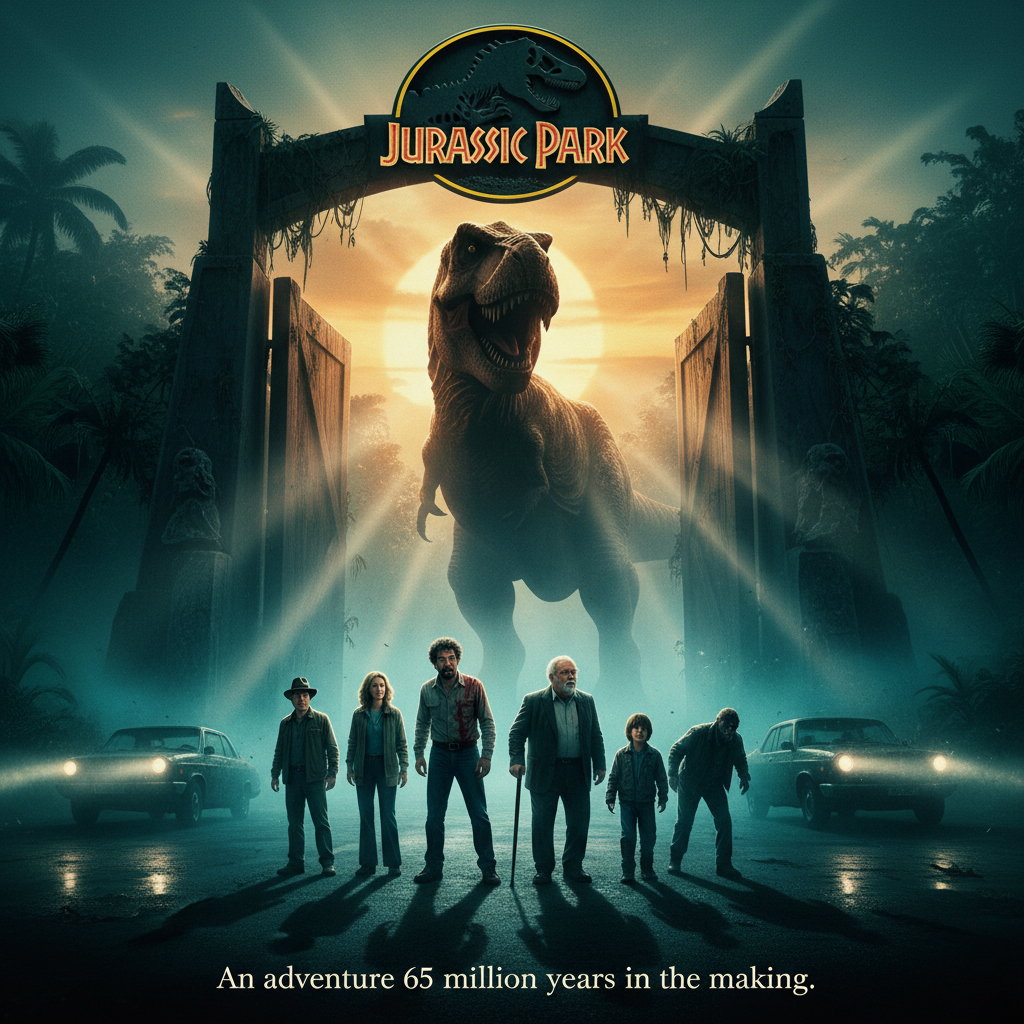

In [47]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

# Display the poster that was saved in task 8b
# output_path was created in the previous cell
if output_path.exists():
    display(Image(filename=str(output_path), width=600))
else:
    print(f"Poster not found at {output_path}. Make sure you ran task 8b first!")


---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [60]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2.1

fatal: a branch named 'homework-2.1' already exists


### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [61]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator v2"

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    ../scripts/.python-version
	deleted:    ../scripts/README.md
	deleted:    ../scripts/pyproject.toml
	deleted:    ../scripts/uv.lock

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.gitignore
	../.python-version
	../README.md
	../lectures/
	../pyproject.toml
	../uv.lock

no changes added to commit (use "git add" and/or "git commit -a")


In [62]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2.1

branch 'homework-2.1' set up to track 'origin/homework-2.1'.


remote: 
remote: Create a pull request for 'homework-2.1' on GitHub by visiting:        
remote:      https://github.com/rafaelyaptangco/ai-engineering-fordham/pull/new/homework-2.1        
remote: 
To https://github.com/rafaelyaptangco/ai-engineering-fordham.git
 * [new branch]      homework-2.1 -> homework-2.1


### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [59]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

D	scripts/.python-version
D	scripts/README.md
D	scripts/pyproject.toml
D	scripts/uv.lock
Your branch is up to date with 'origin/main'.


Switched to branch 'main'


Already up to date.
f18abcf Merge pull request #1 from rafaelyaptangco/homework-2
9a79b21 Complete homework 2: Movie Poster Generator
14e57f1 Complete homework 1 v2


---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [63]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # Step 1: Extract structured movie data from description
    movie = await async_extract_movie(description)
    
    # Step 2: Generate poster prompt from movie data
    poster_prompt = generate_poster_prompt(movie)
    
    # Step 3: Generate the poster image using Gemini
    google_client = genai.Client()
    
    # Make sure temp directory exists
    os.makedirs("temp", exist_ok=True)
    
    # Generate the image
    response = google_client.models.generate_content(
        model="gemini-2.5-flash-image",
        contents=[poster_prompt]
    )
    
    # Step 4: Save the image to a file
    from pathlib import Path
    
    # Create a safe filename from the movie title
    safe_title = "".join(c if c.isalnum() or c in (' ', '-', '_') else '' for c in movie.title)
    safe_title = safe_title.replace(' ', '_')
    output_path = Path(f"temp/poster_{safe_title}.png")
    
    # Extract and save the image
    for part in response.parts:
        if part.inline_data is not None:
            image = part.as_image()
            image.save(output_path)
            print(f"Poster saved to {output_path}")
            break
    else:
        raise ValueError("No image found in response")
    
    # Step 5: Return the movie object and path to the poster
    return (movie, str(output_path))

In [ ]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
Five years after Expedition 33's desperate mission to destroy the Paintress, 
a new generation discovers that her curse was not fully broken. The remnants 
of her power have begun to coalesce, creating shadowy echoes of the original 
cycle. A young scholar named Eloise, who lost her family to the Paintress's 
legacy, leads Expedition 34 on a journey through the decaying opulence of 
Belle Époque France. Joined by a war-weary veteran named Julien and a 
mysterious artist named Celeste who can see the Paintress's fading brushstrokes 
in reality itself, they must venture into the forgotten ateliers and abandoned 
mansions where the Paintress's influence still lingers. The film unfolds in a 
world where time itself has become fractured—moments of the past bleed into 
the present, creating a surreal landscape where 1890s Parisian streets overlap 
with modern ruins. The visual style blends the rich, warm tones of oil paintings 
with the cold, desaturated palette of a world losing its color. Every frame 
feels like a living canvas, with characters moving through environments that 
shift between reality and painted illusion. The mood is one of melancholic 
determination—a race against time where each victory comes at a cost, and the 
line between art and reality becomes dangerously blurred. The setting moves 
from the grand boulevards of Paris to hidden underground galleries where the 
Paintress's unfinished works still pulse with malevolent energy, culminating 
in a confrontation where the very nature of creation and destruction hangs in 
the balance.
"""

# Uncomment to run:
# movie, poster_path = await movie_to_poster(my_movie_description)
# print(f"Generated poster for: {movie.title}")
# print(movie.model_dump_json(indent=2))
# display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!